In [1]:
import random
import math
import numpy as np

from math import sin, cos, acos

import copy


import sys, os, time

from qinfer import LiuWestResampler
from qinfer import utils

from qiskit import IBMQ
from qiskit import QuantumCircuit, execute, Aer

import qiskit.ignis.verification.randomized_benchmarking as rb

IBMQ.load_account()

Failed to import duecredit due to No module named 'duecredit'
/home/alan/aur/miniconda3/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "
/home/alan/aur/miniconda3/lib/python3.8/site-packages/qinfer/parallel.py:61: UserWarning: Could not import IPython parallel. Parallelization support will be disabled.
  warnings.warn(


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
import matplotlib.pyplot as plt
import seaborn as sbs

import smc_unitary as smc
Distribution = smc.Distribution

sbs.set(style="darkgrid")

%matplotlib inline

In [3]:
def random_circuit(n_qubits):
    length_vector = [1]
    n_seeds = 1
    
    initial_list = list(range(0, n_qubits))    
    rb_pattern = []
    
    while len(initial_list) > 1:
        sample = random.sample(initial_list, 2)
        [initial_list.remove(i) for i in sample]
        rb_pattern.append(sample)
    
    if len(initial_list) == 1:
        rb_pattern.append([initial_list[0]])
    
    
    circuit, xdata = rb.randomized_benchmarking_seq(
        length_vector = [1],
        nseeds = 1,
        rb_pattern = rb_pattern
        )
    circuit = circuit[0][0]
    cregs = circuit.cregs
    
    circuit.remove_final_measurements(inplace=True)
    circuit.cregs = cregs
    
    for i in range(n_qubits):
        circuit.barrier(i)
        if (round(random.random())):
            circuit.x(i)
            circuit.barrier(i)
    
    return circuit

In [4]:
# Only one qubit for now
def design_circuit(n_qubits, unitary_arr, circuit=None):
    
    if circuit is None:
        circuit = QuantumCircuit(n_qubits, n_qubits)
    
    if unitary_arr is not None:
        circuit.rx(unitary_arr[0], 0)
        circuit.rz(unitary_arr[1], 0)
    
    circuit.measure(list(range(n_qubits)), list(range(n_qubits)))
    return circuit

In [35]:
dist = Distribution(n_points=200, n_qubits=1)

In [41]:
circuit = random_circuit(n_qubits)
circuit.draw()

┌───┐ ░ ┌───┐ ░ ┌───┐ ░ 
qr_0: ┤ Z ├─░─┤ Z ├─░─┤ X ├─░─
      └───┘ ░ └───┘ ░ └───┘ ░ 
cr_0: ════════════════════════

In [60]:
u2_gates = dist.next_experiment()   
tmp_circuit = copy.deepcopy(circuit)
tmp_circuit = design_circuit(n_qubits, u2_gates, circuit=tmp_circuit)

In [61]:
u2_gates

array([5.34156439, 4.37537962])

In [62]:
tmp_circuit.draw()

┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌────────────┐┌────────────┐┌─┐
qr_0: ┤ Z ├─░─┤ Z ├─░─┤ X ├─░─┤ RX(5.3416) ├┤ RZ(4.3754) ├┤M├
      └───┘ ░ └───┘ ░ └───┘ ░ └────────────┘└────────────┘└╥┘
cr_0: ═════════════════════════════════════════════════════╩═

In [63]:
job = execute(tmp_circuit, backend, shots=1)

result = job.result()
outcome = list(map(int, list(list(result.get_counts(tmp_circuit).keys())[0]))) 

KeyboardInterrupt: 

array([5.67384751, 0.53825995])

In [ ]:
dist.measure(outcome, u2_gates)

In [ ]:
sbs.scatterplot(dist.points[:,0],
                dist.points[:,1],
                size=dist.weights,
                sizes=(20, 200),
                hue=dist.weights)

In [309]:
provider = IBMQ.get_provider(group='open', project='main')
backend = provider.get_backend('ibmq_vigo')


n_qubits = 1
n_circuits_sampled = 1

for __ in range(n_circuits_sampled):
    
    
    
    circuit = random_circuit(n_qubits)
    while len(circuit) > 6:
            circuit = random_circuit(n_qubits)
    
    result_data = {}
    result_data['risk'] = []
    result_data['mean'] = []
    result_data['counts'] = []
    result_data['circuit'] = circuit

    dist = Distribution(n_points=1000, n_qubits=1)
    for _ in range(240):

        u2_gates = dist.next_experiment()     

        print(u2_gates)

        tmp_circuit = copy.deepcopy(circuit)
        tmp_circuit = design_circuit(n_qubits, u2_gates, circuit=tmp_circuit)

        job = execute(tmp_circuit, backend, shots=1)

        result = job.result()
        outcome = list(map(int, list(list(result.get_counts(tmp_circuit).keys())[0])))     

        best_estimate = dist.calc_best_experiment()
        print(best_estimate)
               
        
        tmp_circuit = copy.deepcopy(circuit)
        tmp_circuit = design_circuit(n_qubits, best_estimate, circuit=tmp_circuit)

        job = execute(tmp_circuit, backend, shots=4096)
        result = job.result()
        outcome_full = result.get_counts(tmp_circuit)

        dist.measure(outcome, u2_gates)

        result_data['risk'].append(dist.calc_bayes_risk())
        result_data['mean'].append(dist.calc_bayes_mean())
        result_data['counts'].append(outcome_full)

        print(result_data['risk'][-1], result_data['mean'][-1])

    result_data['distrubtion'] = dist
    results.append(result_data)

[0.46183724 5.03975014]
None
6.34452856117738 [-4.08866099e-01 -2.41018143e-16]
[0.4204554  5.89140439]
[ 1.15798069e+00 -2.21827764e-16]
6.124971497166325 [-4.36088992e-01 -2.59747735e-16]
[0.92342175 1.41951884]
[ 1.13501661e+00 -1.85940673e-16]
6.068197780511663 [2.3911659  3.09774842]
[3.84512264 3.48088959]
[0.84718803 3.09905729]
5.8772797662532925 [2.32089107 3.08398726]
[3.92463148 2.51272072]
[0.84237576 3.11928032]
5.779826980159813 [2.27039703 3.09360227]
[3.83489054 1.67905587]
[0.82460335 3.13769681]
6.0933569456470735 [2.5049924  3.09279491]
[4.05418793 6.05976847]
[2.5049924  3.09279491]
6.17033247860327 [2.60384569 3.09020449]
[3.65340102 0.42163909]
[2.60384569 3.09020449]
6.300351710588354 [2.67692458 3.10252362]
[3.6434718 0.5189042]
[2.67692458 3.10252362]
6.4186315410092005 [2.75671586 3.11057694]
[3.54049427 5.7324578 ]
[2.75671586 3.11057694]
6.526104492924583 [2.82866165 3.11561142]
[3.21259205 2.19686481]
[2.82866165 3.11561142]
6.621215309959103 [2.85600782 3.

Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


5.978267770027677 [3.18179975 3.0593135 ]
[3.3352457  1.18931674]
[1.70084195 3.1094788 ]
6.0242496766625795 [3.23481607 3.06948821]
[2.84080388 4.20023676]
[1.77163739 3.11279287]
5.756988841396412 [3.47767275 3.0551491 ]
[2.56690787 3.26151114]
[1.98473995 3.05273962]
5.5763944493483555 [3.2133179  3.02475889]
[2.21709692 5.92114064]
[3.2133179  3.02475889]
5.570606023962096 [3.13650742 3.02389119]
[3.49688205 5.05051689]
[3.13650742 3.02389119]
5.507865912162647 [2.96530715 2.99355601]
[3.27286296 4.83298664]
[4.42414902 2.89139071]
5.510901921407505 [2.95490864 3.00724108]
[3.73678031 3.14833539]
[4.39337911 2.88784914]
5.544979048841995 [3.00725069 3.00818314]
[3.448485   3.93484085]
[4.44866576 2.89255411]
5.566769275375932 [3.02822682 3.02193553]
[3.46382231 3.62140311]
[4.45490177 2.89154317]
5.584705758020589 [3.05336398 3.03369559]
[3.03623038 5.91320287]
[3.05336398 3.03369559]
5.536217533524094 [3.00247498 3.04036475]
[3.87552286 3.42808257]
[3.00247498 3.04036475]
5.575802

Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


5.263252550796263 [2.76203715 2.94667951]
[3.45448957 2.39553213]
[2.76203715 2.94667951]


Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


5.309620644963955 [2.79221408 2.94256015]
[2.92984076 2.33327363]
[2.79221408 2.94256015]
5.322281434834324 [2.77675534 2.93549562]
[3.54048327 3.39601529]
[2.77675534 2.93549562]
5.015419233272502 [2.54280343 2.93122088]
[3.63990547 3.04575207]
[3.85495871 2.77936654]
5.04980740553545 [2.52497715 2.93049006]
[3.8105696  0.46242272]
[3.81209357 2.78440662]
5.086813122974365 [2.5233642  2.93333377]
[3.84294746 4.23598462]
[3.79179949 2.78406092]
4.992233263912744 [2.50566678 2.92192032]
[3.43635333 0.42009624]
[3.82123497 2.78567309]
5.009632913189106 [2.4801684  2.91377759]
[3.74230476 1.20105164]
[3.7734153  2.78927383]
5.034433385911557 [2.45956733 2.91246223]
[3.52268669 4.0466687 ]
[3.73924593 2.7895647 ]
5.054069311542704 [2.43834969 2.90675824]
[3.60172016 4.75073074]
[3.69870803 2.79213566]
5.074621271814491 [2.42074442 2.90323084]
[3.82792038 2.05260262]
[3.66453301 2.79372803]
5.0108266379973445 [2.43811287 2.90355902]
[4.06682144 0.84444601]
[3.7204986  2.79831537]
5.00158030

Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


4.992842631413521 [2.47398576 2.91536635]
[3.72760733 4.52916952]
[3.78206801 2.81181422]
5.008253713691975 [2.45170624 2.91265622]
[3.85530132 2.36706666]
[3.75688435 2.81301485]
5.021949764728756 [2.4320297  2.91117461]
[3.43574408 5.99677147]
[3.73900114 2.81247975]
5.0285973357342595 [2.41002384 2.9043381 ]
[4.33697352 4.64421584]
[3.70925153 2.81354917]


Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


5.016448983953182 [2.43660522 2.91156747]
[3.54973392 5.39391296]
[3.74139839 2.81042685]
4.979637378660271 [2.51010552 2.92995456]
[3.52336181 1.5631347 ]
[3.84002812 2.8074003 ]
4.993867421253375 [2.48868059 2.92411196]
[3.63603099 2.95904794]
[3.8051971  2.81118677]
4.953951278597852 [2.54253797 2.93169888]
[3.79262584 2.40845857]
[3.87465346 2.80418032]
4.920365599277202 [2.56782681 2.92950299]
[3.7775585  4.80448655]
[3.8998548  2.80086466]
4.93931415575439 [2.55537221 2.93086073]
[3.74450492 5.38156736]
[3.88498366 2.80438803]


Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


4.958656091782269 [2.54016351 2.93188821]
[3.5851252  2.87740946]
[3.86651518 2.80823204]
4.91581849622484 [2.58378193 2.9367462 ]
[3.6537989  5.14379182]
[3.93681068 2.79460199]
4.881112493276052 [2.61301071 2.93377578]
[3.73678874 1.94461245]
[3.98452096 2.78047473]
4.854377144573889 [2.62925434 2.92753382]
[3.85124098 0.57912265]
[4.00582375 2.77201742]
4.784801675935296 [2.60065307 2.80649692]
[3.63797895 3.47468573]
[3.92927345 2.65877076]
4.804470180590419 [2.58921372 2.81141096]
[3.67347909 1.28927051]
[3.89276721 2.67619099]


Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


4.750232060090988 [2.60780849 2.79990054]
[3.68001323 1.07639508]
[3.96919133 2.63557563]
4.762254476729718 [2.59210705 2.80429055]
[3.82595814 1.37268902]
[3.94260606 2.64893305]
4.778731524446817 [2.57941705 2.80902729]
[3.85169936 0.93184832]
[3.93407512 2.66016687]
4.7952791548122695 [2.57059794 2.81424521]
[3.97590431 2.04982738]
[3.93022402 2.67265816]
4.812453223216189 [2.5759746  2.82225875]
[3.94162753 3.83457117]
None
4.771194201113847 [2.56011284 2.80762429]
[3.58486079 3.87699119]
[3.91330032 2.65402786]
4.773047619964215 [2.53938624 2.81090399]
[4.00870503 4.08439225]
[3.87055646 2.66696846]
4.750119897627 [2.53448955 2.79813268]
[3.79716803 5.8295359 ]
[3.84391972 2.65186332]
4.738713214335039 [2.57260334 2.78921161]
[3.78485257 1.93549286]
[3.88473973 2.63482289]
4.726388282361043 [2.60804202 2.782396  ]
[3.71241698 3.49360887]
[3.91745751 2.6224547 ]
4.734833826623718 [2.5891044 2.785205 ]
[3.39049363 6.11584487]
[3.89653031 2.62919016]
4.733350123784551 [2.5732931 2.78

Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


4.752394638698194 [2.65690354 2.70889952]
[3.74709921 5.37056043]
[3.78818764 2.66366443]


Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


4.775836581247807 [2.65272038 2.72065129]
[3.69013826 4.30003093]
[3.75398509 2.67821316]
4.702582216788338 [2.65237962 2.68868691]
[3.9967033  5.96764994]
[3.8541939 2.6365599]
4.688213179317767 [2.64199995 2.68080657]
[3.88366766 4.47170079]
[3.85090779 2.63332995]
4.6787838396725165 [2.66150729 2.67270792]
[3.6472199  5.37875539]
[3.87993385 2.62751744]
4.674018676727742 [2.70738612 2.65933893]
[3.66443222 4.53372504]
[3.93831222 2.604921  ]
4.599065248319411 [2.80205319 2.62521888]
[3.59422623 5.4954249 ]
[2.80205319 2.62521888]
4.654735451624688 [2.78270861 2.67530455]
[4.07183837 3.28450751]
[3.96793808 2.6151271 ]
4.678046363094119 [2.79894686 2.665066  ]
[4.24338592 5.40132703]
None
4.596582386106988 [2.72643253 2.6899623 ]
[3.50312048 2.81133063]
[3.84000359 2.63693275]
4.563742826322513 [2.69950276 2.68244966]
[3.31685317 4.45686086]
[3.78528614 2.63539165]
4.537581930538317 [2.67721682 2.67856979]
[3.57659058 1.56556201]
[3.73937786 2.6373918 ]


Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


4.518207421899292 [2.65536411 2.66938974]
[3.79931225 3.49137493]
[3.69436479 2.63963158]
4.5167452519864035 [2.64188987 2.66063915]
[3.51595986 4.80957009]
[3.65983383 2.64835566]
4.504859542221165 [2.6267115  2.65421522]
[3.53813063 3.93192476]
[3.62288259 2.65358226]
4.4996777911542205 [2.6157259  2.64792679]
[3.85988534 0.66570122]
[3.59196835 2.65893981]


Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


4.511742972552412 [2.6145536  2.63970172]
[3.68746399 1.7331353 ]
[3.569232   2.66562668]
4.48055724392742 [2.62147804 2.66917619]
[3.6401545  2.23228578]
[3.6592915  2.65406498]


Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


4.514875275645781 [2.67816065 2.68889213]
[3.21922497 0.69285372]
[3.77393975 2.62633941]


Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


4.4928000464218245 [2.65929206 2.68686559]
[3.8090421  1.99395173]
[3.74045023 2.62914906]
4.51262475967115 [2.697587   2.69767601]
[3.64538517 0.79483495]
[3.80407644 2.60409651]
4.491115401405527 [2.67407104 2.68981199]
[3.44702694 1.75391003]
[3.76801051 2.60556472]
4.469686210152956 [2.65430252 2.68559841]
[3.5902705  3.97924383]
[3.73591414 2.60961511]
4.450998636778599 [2.63412082 2.68065093]
[3.77231693 2.48773759]
[3.70417234 2.61695195]
4.438145665060862 [2.61559146 2.6771174 ]
[3.61281744 3.93732245]
[3.67470869 2.63118323]


Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


4.423539989020265 [2.59832575 2.67383237]
[3.7302613  5.63577124]
[3.64701453 2.64254356]
4.412702296428071 [2.58251427 2.67116908]
[3.36992625 2.13089009]
[3.62110923 2.6569533 ]
4.514171868721324 [2.70838269 2.6414503 ]
[3.58446128 0.72532346]
[2.70838269 2.6414503 ]
4.532629081029667 [2.73170668 2.6451393 ]
[3.44267826 0.6517242 ]
[2.73170668 2.6451393 ]
4.543617973738652 [2.74820301 2.64798624]
[3.87103378 0.94123055]
[2.74820301 2.64798624]
4.544611865063036 [2.79722473 2.65209513]
[3.32462502 1.03165676]
[2.79722473 2.65209513]
4.54700817399043 [2.8081442  2.65494266]
[3.54753824 1.42578244]
[2.8081442  2.65494266]
4.543047026238363 [2.8356341  2.65889091]
[2.97771906 0.50337276]
[2.8356341  2.65889091]
4.334841976403163 [3.15322703 2.62858455]
[3.30782569 0.86325568]
[3.15322703 2.62858455]
4.354479688229111 [2.95594597 2.67308087]
[3.18690361 4.17364393]
[2.95594597 2.67308087]
4.465632008924129 [2.83877162 2.56828644]
[3.55208566 3.65242664]
[1.83595203 2.61020737]


Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


4.42997875092884 [2.87577005 2.56410262]
[3.11784642 4.26752982]
[1.92001054 2.60925057]
4.450592137037131 [2.84415422 2.52511937]
[3.78537465 2.34670408]
[1.80489842 2.59061963]
4.435425501775162 [2.51343698 2.54733013]
[3.82647533 3.06075372]
[1.29022331 2.5206072 ]
4.433888474092481 [2.45938701 2.55476122]
[3.89108424 2.35492303]
[1.13231418 2.52825173]
4.557607034636372 [2.53528413 2.5881043 ]
[3.63916026 5.83441556]
[2.53528413 2.5881043 ]
4.586149621271229 [2.56840272 2.58732625]
[3.76072684 5.16478638]
[2.56840272 2.58732625]
4.5960142926259095 [2.61425861 2.58339406]
[3.64418983 2.95357638]
[2.61425861 2.58339406]
4.616208227834868 [2.65621936 2.58302036]
[3.47265607 0.74282626]
[2.65621936 2.58302036]
4.653893716767705 [2.69101432 2.5901433 ]
[3.37997782 2.26448371]
[2.69101432 2.5901433 ]


Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


4.699017353529259 [2.72227773 2.60337583]
[4.13869199 0.60071325]
[2.72227773 2.60337583]
4.7139012464942605 [2.89050889 2.60570151]
[3.12409003 0.98873005]
[1.74123437 2.57109645]
4.412854374223899 [2.61593035 2.55372705]
[4.31948888 1.51382167]
[1.65180906 2.47863189]
4.351785366683439 [2.48227013 2.53260653]
[3.71489634 0.63034309]
[2.48227013 2.53260653]
4.283240529301795 [2.55603244 2.51418846]
[3.76811658 2.58557598]
[2.55603244 2.51418846]
4.215333235304482 [2.62194891 2.50107953]
[2.7588692  0.34182527]
[2.62194891 2.50107953]
4.316615450349814 [2.60520806 2.50874345]
[2.40462262 3.51619597]
[2.60520806 2.50874345]


Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


3.973126656194982 [2.83106768 2.48299366]
[3.64728811 0.25668638]
[2.83106768 2.48299366]


Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


3.9723402494640276 [2.75450753 2.45225283]
[3.78470553 1.96671565]
[2.75450753 2.45225283]
3.9120736794741053 [2.78073805 2.44251988]
[4.14392211 1.75482422]
[2.78073805 2.44251988]
3.8934869650951365 [2.78248602 2.43974613]
[3.09707629 4.59685455]
[2.78248602 2.43974613]
3.8329700001167604 [2.82149021 2.43309733]
[3.49533355 3.67015457]
[2.82149021 2.43309733]
3.771380215960433 [2.85281557 2.42352886]
[2.57829719 2.04439223]
[2.85281557 2.42352886]
3.7887957778843253 [2.86539663 2.42276062]
[3.40100547 1.82653142]
[2.86539663 2.42276062]
3.7256103787403663 [2.90001266 2.41278332]
[3.33980779 0.60194322]
[2.90001266 2.41278332]


Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


3.673167221172313 [2.93023766 2.40484149]
[2.71871464 1.93570767]
[2.93023766 2.40484149]
3.6564421604569914 [2.95767107 2.39968863]
[3.42675375 2.97225957]
[2.95767107 2.39968863]
4.093628202763264 [2.66642749 2.48758092]
[4.73564799 1.48323987]
[2.66642749 2.48758092]


Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


4.12193461150657 [2.65200978 2.48743792]
[3.96191805 3.5606247 ]
[1.86725331 2.43699127]
4.50806367868237 [2.4780749  2.55997999]
[3.86959228 0.34238196]
[1.3467981  2.56476785]
4.707139444471866 [2.5391293  2.62587745]
[1.83901961 0.19956808]
[2.5391293  2.62587745]
4.5193180720569055 [2.94722445 2.54706842]
[3.49182274 2.2027188 ]
[2.94722445 2.54706842]
4.434828636011988 [2.9192438  2.56662696]
[2.79150874 2.74399545]
[2.9192438  2.56662696]
4.503632516194885 [2.93837044 2.56674945]
[2.81096764 1.78639863]
[2.93837044 2.56674945]
4.564954297128777 [2.95081301 2.56766362]
[3.25755249 1.30949117]
[2.95081301 2.56766362]
4.563381776301133 [2.55838849 2.58199678]
[4.16294676 2.21726216]
[1.54975352 2.55069057]
5.0832892905869445 [2.46866292 2.64269652]
[3.41087209 0.5693615 ]
[3.81223722 2.67009089]
4.883167272249682 [2.31850123 2.57025635]
[3.73043631 3.46758305]
[1.11778896 2.56438896]
4.993593112620407 [2.29860459 2.58968866]
[4.47167438 3.85775402]
[1.05746636 2.59165568]
4.93615317

Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


4.970538785844024 [2.20407024 2.78266809]
[3.29449644 5.45894857]
[0.92035882 2.68897549]
5.313565013167773 [2.32024517 2.68692857]
[3.25948826 1.12871795]
[2.32024517 2.68692857]
5.452657180255228 [2.33295112 2.68476636]
[3.57489939 0.81710694]
[2.33295112 2.68476636]
5.598745131523624 [2.38245027 2.67672221]
[3.86974133 0.26625785]
[2.38245027 2.67672221]
5.718646908737711 [2.47003856 2.66544545]
[3.85422753 0.75544451]
[2.47003856 2.66544545]
5.820331608245168 [2.56395254 2.65173013]
[3.62649802 4.65127845]
[2.56395254 2.65173013]
5.923960890838479 [2.63787491 2.64122743]
[3.11366697 0.04773841]
[2.63787491 2.64122743]
6.017198799048683 [2.64689782 2.64672554]
[2.92125873 2.58905684]
[2.64689782 2.64672554]
5.763936445781413 [3.03462484 2.6587079 ]
[2.80114433 3.23104478]
[3.03462484 2.6587079 ]
5.817680084598675 [3.00298449 2.66255735]
[3.42907742 1.63140962]
[3.00298449 2.66255735]
5.84477361035747 [3.06932224 2.66492197]
[3.15016487 5.6044766 ]
[3.06932224 2.66492197]
5.339993756

Future exception was never retrieved
future: <Future finished exception=ConnectionClosed('WebSocket connection is closed: code = 4002 (private use), no reason')>
websockets.exceptions.ConnectionClosed: WebSocket connection is closed: code = 4002 (private use), no reason


5.340801922652479 [3.04432944 2.61919868]
[2.85403853 3.00039108]
[3.04432944 2.61919868]
5.378469295904123 [3.00141033 2.62098319]
[3.36313625 3.0207427 ]
[3.00141033 2.62098319]
5.370183528204825 [3.05464299 2.61928695]


In [77]:
best_estimate

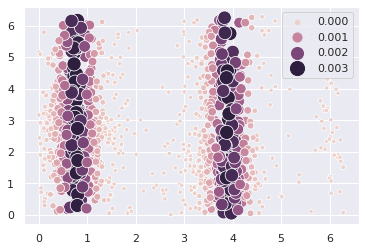

In [114]:
sbs.scatterplot(dist.points[:,0],
                dist.points[:,1],
                size=dist.weights,
                sizes=(20, 200),
                hue=dist.weights)

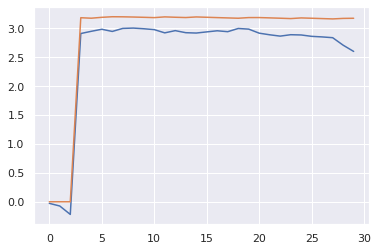

In [66]:
plt.plot(results[-1]['mean'])

In [71]:
len(results)

10

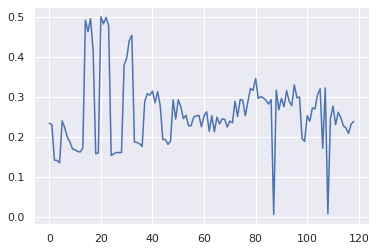

In [310]:
plt.plot([1 - (max(results[-1]['counts'][i]['1'], results[-1]['counts'][i]['0']) / 4096) for i in range(1, 120)])

In [159]:
results[-4]['counts']

[{'0': 4063, '1': 33},
 {'0': 2588, '1': 1508},
 {'0': 2492, '1': 1604},
 {'0': 2551, '1': 1545},
 {'0': 2465, '1': 1631},
 {'0': 2653, '1': 1443},
 {'0': 2262, '1': 1834},
 {'0': 2573, '1': 1523},
 {'0': 4056, '1': 40},
 {'0': 535, '1': 3561},
 {'0': 671, '1': 3425},
 {'0': 1366, '1': 2730},
 {'0': 1315, '1': 2781},
 {'0': 1198, '1': 2898},
 {'0': 1272, '1': 2824},
 {'0': 1169, '1': 2927},
 {'0': 3653, '1': 443},
 {'0': 1156, '1': 2940},
 {'0': 1183, '1': 2913},
 {'0': 1011, '1': 3085},
 {'0': 1000, '1': 3096},
 {'0': 987, '1': 3109},
 {'0': 1004, '1': 3092},
 {'0': 984, '1': 3112},
 {'0': 3551, '1': 545},
 {'0': 967, '1': 3129},
 {'0': 850, '1': 3246},
 {'0': 912, '1': 3184},
 {'0': 952, '1': 3144},
 {'0': 908, '1': 3188},
 {'0': 821, '1': 3275},
 {'0': 825, '1': 3271},
 {'0': 833, '1': 3263},
 {'0': 869, '1': 3227},
 {'0': 907, '1': 3189},
 {'0': 824, '1': 3272},
 {'0': 957, '1': 3139},
 {'0': 817, '1': 3279},
 {'0': 847, '1': 3249},
 {'0': 785, '1': 3311},
 {'0': 729, '1': 3367},
 

In [228]:
def bootstrap(result, samples=900, repeats=1000):
    sampler = []
    for i in result:
        for _ in range(result[i]):
            sampler.append(int(i))
            
    target = int(max(result.keys(), key=lambda key: result[key]))
    
    probs = []
    
    for _ in range(repeats):
        tally = 0
        for i in range(samples):
            sample = sampler[random.randint(0, len(sampler) - 1)]
            
            if sample == target:
                tally += 1
        
        probs.append(tally / samples)
    return probs

In [229]:
bootstrap(results[-4]['counts'][10], repeats=10, samples=10)

[0.7, 1.0, 0.7, 0.6, 0.8, 0.7, 0.6, 0.9, 0.9, 0.8]

In [591]:
len(results[17]['circuit'])

6

In [593]:
import pickle

In [594]:
f = open("rb_single.pkl", "wb")
pickle.dump(results, f)
f.close()

In [587]:
n_repeats=64
samples=64
tar_point = 17

x_coords = np.array([[i] * n_repeats for i in range(len(results[tar_point]['counts']))][1:]).flatten()
y_coords = 1 - np.array([bootstrap(res, samples=samples, repeats=n_repeats) for res in results[tar_point]['counts'][1:]]).flatten()

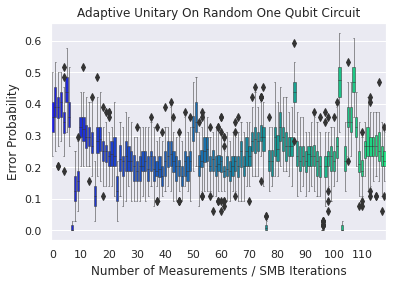

In [590]:
p_box = sbs.boxplot(x_coords, y_coords, palette='winter', linewidth=0.5)

# ax = sbs.lineplot(
#     range(len(results[tar_point]['risk'])), 
#     [i / max(results[tar_point]['risk']) / 2 for i in results[tar_point]['risk']] , 
#     marker='.', linestyle='--',markersize=10,
#     label='Risk')

ax.lines[1].set_marker('.')
ax.lines[1].set_linestyle('-')

#plt.legend()
plt.ylabel('Error Probability')
plt.xlabel('Number of Measurements / SMB Iterations')
plt.title('Adaptive Unitary On Random One Qubit Circuit')

p_box.axes.set_xticklabels([i if (0 == i % 10) else '' for i in range(121)])
#plt.show()
plt.savefig("figs/120_unitary.pdf")
#_box.set(xticks=[i * 10 for i in range(12)])
#plt.axes(xticks=[i * 10 for i in range(12)])

In [563]:
?plt.axes

In [553]:
?sbs.boxplot

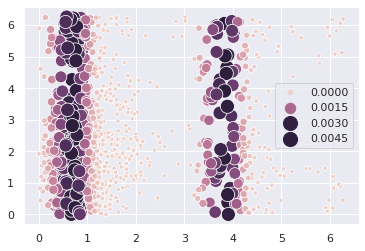

In [526]:
d_targ = results[17]['distrubtion']

sbs.scatterplot(d_targ.points[:, 0], d_targ.points[:, 1], 
size=d_targ.weights,
                sizes=(20, 200),
                hue=d_targ.weights
)

In [ ]:
sbs.lineplot(x_coords, y_coords, label="Error Rate")


ax = sbs.lineplot(
    range(len(results[tar_point]['risk'])), 
    [i / max(results[tar_point]['risk']) / 2 for i in results[tar_point]['risk']] , 
    marker='.', linestyle='--',markersize=10,
    label='Risk')

ax.lines[1].set_marker('.')
ax.lines[1].set_linestyle('-')


plt.ylabel('Error Probability')
plt.xlabel('Number of Measurements')
plt.title('Adaptive Unitary Method')

In [ ]:
#ax=sbs.lineplot(results[-4]['mean'])

#plt.plot(results[-4]['mean'])
plt.plot([1 - (max(results[-4]['counts'][i]['1'], results[-4]['counts'][i]['0']) / 4096) for i in range(1, 120)])

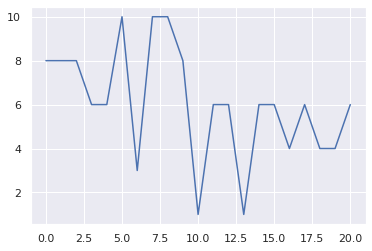

In [146]:
plt.plot([len(results[i]['circuit']) for i in range(len(results))])

In [81]:
len(circuit)

4

In [109]:
for i in results:
    print(len(i['mean']))

30
30
30
30
30
30
30
30
30
30
60
60
60
60
60
60
60
120
120
120
120


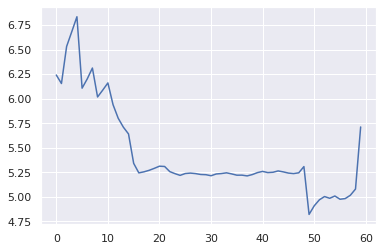

In [275]:
plt.plot(results[-6]['risk'])

In [ ]:
n_repeats=64
samples=64
tar_point = 17

x_coords = np.array([[results[tar_point]] * n_repeats for i in range(len(results[tar_point]['counts']))][1:]).flatten()
y_coords = 1 - np.array([bootstrap(res, samples=samples, repeats=n_repeats) for res in results[tar_point]['counts'][1:]]).flatten()

In [411]:
best_found(results[0]['counts'])

{'0': 569, '1': 3527}

In [410]:
def best_found(res):
    return max(res, key=lambda x: max(x['0'], x['1']))
        

In [439]:
results[10]['counts'][0]

{'0': 4076, '1': 20}

In [485]:
e_val = lambda x: 1 - (max(x['counts'][0]['1'], x['counts'][0]['0']) / 4096)
tp_avg = lambda x, i:  sum([x[i][1], x[i + 1][1], x[i + 1][1]]) / 3
                      
#y_init_trend = [tp_avg(i) for i in range(len(results) - 2)]

y_vals = list(map(e_val, results ))
c_vals = [len(res['circuit']) for res in results]
         
    
y_vals_clean = []
c_vals_clean = []
c_vals_count = []
for v, c in zip(y_vals, c_vals):
    if c not in c_vals_clean:
        c_vals_clean.append(c)
        y_vals_clean.append(v)
        c_vals_count.append(1)
    else:
        index = c_vals_clean.index(c)
        c_vals_count[index] += 1
        y_vals_clean[index] += v

y_vals_avg = [v / c for v, c in zip(y_vals_clean, c_vals_count)]
c_y_tuple = list(zip(c_vals_clean, y_vals_avg))
c_y_tuple.sort()

In [486]:
c_y_tuple

[(1, 0.0040283203125),
 (3, 0.1630859375),
 (4, 0.034830729166666664),
 (6, 0.12760416666666666),
 (8, 0.1424560546875),
 (10, 0.11857096354166667)]

In [491]:
trip_avg = np.array([[c_y_tuple[i + 1][0] ,tp_avg(c_y_tuple, i)] for i in range(len(c_y_tuple) - 2)])

In [492]:
trip_avg

array([[3.        , 0.11006673],
       [4.        , 0.07758247],
       [6.        , 0.09667969],
       [8.        , 0.13750543]])

In [584]:
samples = 64
n_repeats = 64

x_coords = np.array([[len(res['circuit'])] * n_repeats for res in results]).flatten()
y_coords_init = 1 - np.array([bootstrap(res['counts'][0], samples=samples, repeats=n_repeats) for res in results]).flatten()
y_coords_final = 1 - np.array([bootstrap(best_found(res['counts']), samples=samples, repeats=n_repeats) for res in results]).flatten()


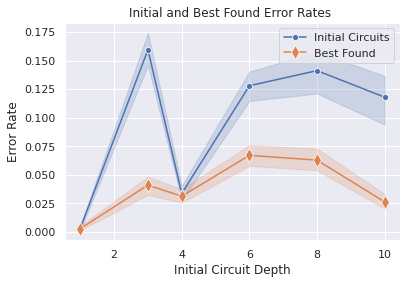

In [585]:
sbs.lineplot(x_coords, y_coords_init,  ci=100, marker='.', markersize=12, label='Initial Circuits')
sbs.lineplot(x_coords, y_coords_final, ci=100, marker='d', markersize=10, label='Best Found')
#sbs.lineplot(trip_avg[:,0], trip_avg[:,1], linestyle='-')


plt.ylabel('Error Rate')
plt.xlabel('Initial Circuit Depth')
plt.title('Initial and Best Found Error Rates ')
plt.savefig('figs/RB_Depth_unitary.pdf')